In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve,precision_score, auc
from imblearn.over_sampling import SMOTE
from boruta import BorutaPy
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

In [ ]:
data = pd.read_csv('C:/Users/danie/OneDrive/Documentos/1 UNIANDES/10 semestre/Tesis/differential-privacy-banking-sector/data/processed/bank-processed.csv', sep=',')
data.shape

(45211, 33)

In [ ]:
X = data.drop(columns=['y'])
Y = data['y']

numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']

scale = StandardScaler()
X[numeric_cols] = scale.fit_transform(X[numeric_cols])

X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Identify Unbalanced Clases

In [334]:
stat = pd.DataFrame(Y.value_counts())
stat['percent'] = stat['count']/Y.shape[0]*100
stat

,count,percent
y,,
0,39922,88.30152
1,5289,11.69848


#### Synthetic Minority Oversampling Technique (SMOTE)

In [335]:

smote = SMOTE(random_state=42)

X_resample, Y_resample = smote.fit_resample(X, Y)

In [336]:
stat2 = pd.DataFrame(Y_resample.value_counts())
stat2['percent'] = stat2['count']/Y_resample.shape[0]*100
stat2

,count,percent
y,,
0,39922,50.0
1,39922,50.0


### **Feature Selection**


#### Boruta Algorithm (wrapper)

In [337]:

rf= xgb.XGBClassifier(eval_metric='logloss')
feat_selector = BorutaPy(rf, n_estimators='auto', verbose=2 ,random_state=42)

feat_selector.fit(X_resample, Y_resample)

feat_selector.support_
X_filtered = X.columns[feat_selector.support_].tolist()



Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	32
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	29
Tentative: 	3
Rejected: 	0
Iteration: 	9 / 100
Confirmed: 	29
Tentative: 	3
Rejected: 	0
Iteration: 	10 / 100
Confirmed: 	29
Tentative: 	3
Rejected: 	0
Iteration: 	11 / 100
Confirmed: 	29
Tentative: 	3
Rejected: 	0
Iteration: 	12 / 100
Confirmed: 	29
Tentative: 	3
Rejected: 	0
Iteration: 	13 / 100
Confirmed: 	29
Tentative: 	3
Rejected: 	0
Iteration: 	14 / 100
Confirmed: 	29
Tentative: 	3
Rejected: 	0
Iteration: 	15 / 100
Confirmed: 	29
Tentative: 	3
Rejected: 	0
Iteration: 	16 / 100
Confirmed: 	30
Tentative: 	2
Rejected: 	0
I

### **Hyperparameter Tuning**

In [338]:

models = {
    'Logit': LogisticRegression(solver='saga', max_iter=10000),
    'Lasso': LogisticRegression(solver='saga', max_iter=10000),
    'Ridge': LogisticRegression(solver='saga', max_iter=10000),
    'ElasticNet': LogisticRegression(solver='saga', max_iter=10000),
    'XGBoost': xgb.XGBClassifier(eval_metric='logloss'),
    'RandomForest': RandomForestClassifier()
}

In [339]:
param_grid = {
    'Logit': {
      'penalty': [None]
    },
    'Lasso': {
        'penalty': ['l1'],
        'C': np.linspace(start=0.001, stop=3, num=3)
    },
    'Ridge': {
        'penalty': ['l2'],
        'C': np.linspace(start=0.001, stop=3, num=3)
    },
    'ElasticNet': {
        'penalty': ['elasticnet'],
        'C': np.linspace(start=0.001, stop=3, num=3),
        'l1_ratio': np.linspace(0, 1, 3) 
    },
    'XGBoost': {},
    'RandomForest': {}
}

In [340]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_models = {}
for name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[name], cv=kf, scoring='roc_auc')
    grid_search.fit(X_train_split, y_train_split)
    best_models[name] = grid_search.best_estimator_

#### Modelos con Clases Desbalanceadas

In [341]:
score={}
for name, model in best_models.items():
    score[name] = cross_validate(model, X=X, y=Y, cv=kf, scoring=['accuracy','roc_auc','precision'], return_estimator=True, )
    print(f"Model: {name}")
    print(f"Best parameters: {model.get_params()}")
    print(f"Accuracy: {score[name]['test_accuracy'].mean():.4f}")
    print(f"AUC ROC: {score[name]['test_roc_auc'].mean():.4f}")
    print(f"Precision: {score[name]['test_precision'].mean():.4f}")
    print("\n")

Model: Logit
Best parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': None, 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy: 0.8998
AUC ROC: 0.8908
Precision: 0.6440


Model: Lasso
Best parameters: {'C': 1.5005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy: 0.8998
AUC ROC: 0.8908
Precision: 0.6443


Model: Ridge
Best parameters: {'C': 1.5005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'sag

#### Modelos con Clases Balanceadas (train)

In [342]:

scores_models = {}

for model_name, model in best_models.items():
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
        
        smote = SMOTE(random_state=42)
        X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

        model.fit(X_train_resample, y_train_resample)
        
        y_scores = model.predict_proba(X_test)[:,1]
        y_hat = [1 if i >= 0.5 else 0 for i in y_scores]

        roc_auc = roc_auc_score(y_test,y_scores)
        prn = precision_score(y_pred = y_hat, y_true = y_test)
        acc = accuracy_score(y_pred = y_hat, y_true = y_test)

        if fold==0:
            scores_models[model_name] = {}
            scores_models[model_name]['train'] = [y_train_resample]
            scores_models[model_name]['test'] = [y_test]
            scores_models[model_name]['test_roc_auc'] = [roc_auc]
            scores_models[model_name]['test_precision'] = [prn]
            scores_models[model_name]['test_accuracy'] = [acc]
        else:
            scores_models[model_name]['train'].append(y_train_resample)
            scores_models[model_name]['test'].append(y_test)
            scores_models[model_name]['test_roc_auc'].append(roc_auc)
            scores_models[model_name]['test_precision'].append(prn)
            scores_models[model_name]['test_accuracy'].append(acc)
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {np.mean(scores_models[model_name]['test_accuracy']):.4f}")
    print(f"ROC (AUC): {np.mean(scores_models[model_name]['test_roc_auc']):.4f}")
    print(f"Precision: {np.mean(scores_models[model_name]['test_precision']):.4f}")
    print("\n")



Model: Logit
Accuracy: 0.8337
ROC (AUC): 0.8690
Precision: 0.3862


Model: Lasso
Accuracy: 0.8338
ROC (AUC): 0.8691
Precision: 0.3865


Model: Ridge
Accuracy: 0.8338
ROC (AUC): 0.8692
Precision: 0.3863


Model: ElasticNet
Accuracy: 0.8338
ROC (AUC): 0.8691
Precision: 0.3865


Model: XGBoost
Accuracy: 0.9013
ROC (AUC): 0.9276
Precision: 0.5772


Model: RandomForest
Accuracy: 0.8931
ROC (AUC): 0.9234
Precision: 0.5360




#### Training set

In [343]:
train_set = pd.DataFrame(scores_models['Lasso']['train'][0].value_counts())
train_set['porc'] = train_set['count']/np.sum(train_set['count'])

train_set

,count,porc
y,,
0,31970,0.5
1,31970,0.5


#### Test set

In [344]:
test_set = pd.DataFrame(scores_models['Lasso']['test'][0].value_counts())
test_set['porc'] = test_set['count']/np.sum(test_set['count'])

test_set

,count,porc
y,,
0,7952,0.879354
1,1091,0.120646


#### **Plot ROC Curve: Model por Fold**

Model: Logit
Best parameters: {'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': None, 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy: 0.8998
AUC ROC: 0.8907
Precision: 0.6440


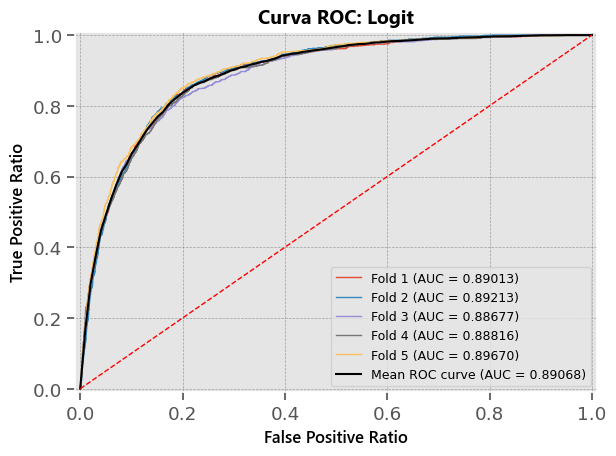

Model: Lasso
Best parameters: {'C': 1.5005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy: 0.8998
AUC ROC: 0.8908
Precision: 0.6443


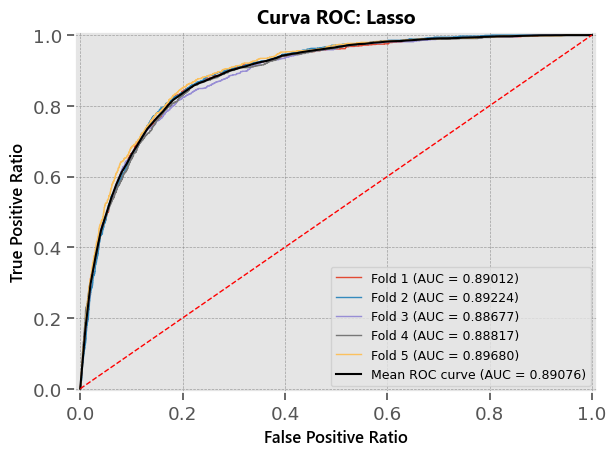

Model: Ridge
Best parameters: {'C': 1.5005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy: 0.8998
AUC ROC: 0.8907
Precision: 0.6445


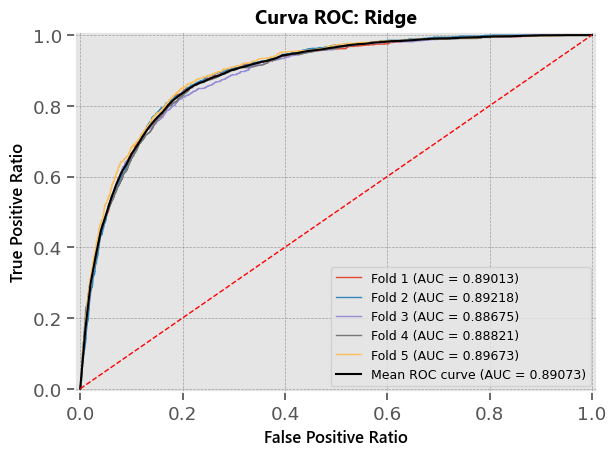

Model: ElasticNet
Best parameters: {'C': 1.5005, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': 1.0, 'max_iter': 10000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'elasticnet', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy: 0.8998
AUC ROC: 0.8908
Precision: 0.6443


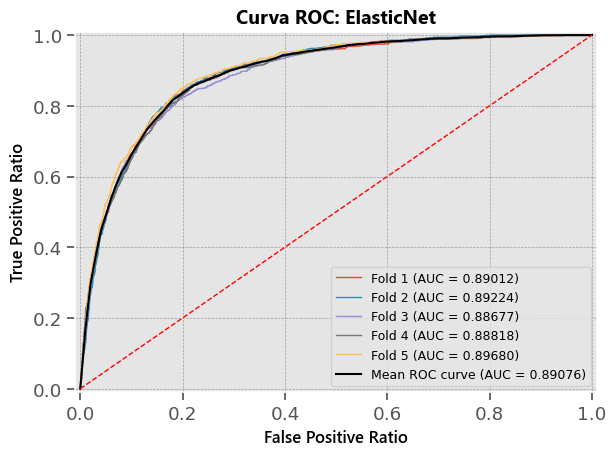

Model: XGBoost
Best parameters: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Accuracy: 0.9071
AUC ROC: 0.9314
Precision: 0.6324


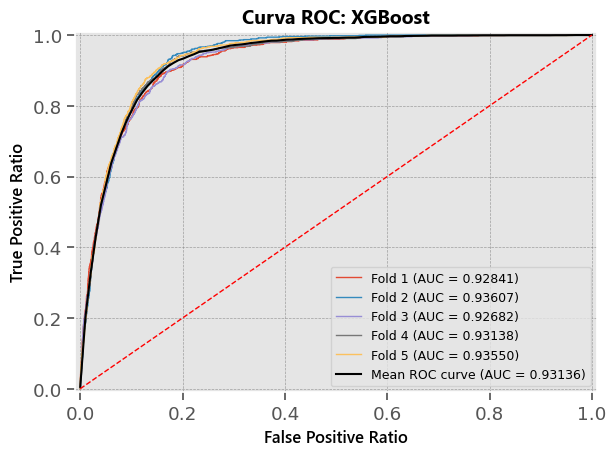

Model: RandomForest
Best parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Accuracy: 0.9042
AUC ROC: 0.9253
Precision: 0.6489


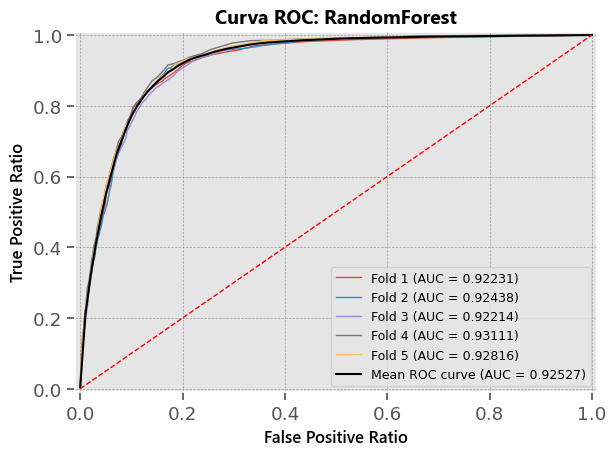

In [345]:

font1 = {'family': 'Segoe UI',
        'color':  'black',
        'weight': 'bold',
        'size': 14,
        }

font2 = {'family': 'Segoe UI',
        'color':  'black',
        'weight': 'semibold',
        'size': 12,
        }

save_model = {}

for model_name, model in best_models.items():
    all_fprs = []
    all_tprs = []
    mean_fpr = np.linspace(0, 1, 100)
    all_acc = []
    all_prn = []
    plt.figure()
    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

        model.fit(X_train, y_train)

        y_scores = model.predict_proba(X_test)[:, 1]
        y_hat = [1 if i >= 0.5 else 0 for i in y_scores]
        fpr, tpr,_ = roc_curve(y_test, y_scores)
        roc_auc = auc(fpr, tpr)
        tpr_interp = np.interp(mean_fpr, fpr, tpr)
        prn = precision_score(y_pred = y_hat, y_true = y_test)
        acc = accuracy_score(y_pred = y_hat, y_true = y_test)
        all_prn.append(prn)
        all_acc.append(acc)
        all_fprs.append(fpr)
        all_tprs.append(tpr_interp)
        plt.plot(fpr, tpr, linewidth=1, label=f'Fold {fold + 1} (AUC = {roc_auc:.5f})')
    mean_tpr = np.mean(all_tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    save_model[model_name] = {}
    save_model[model_name]['model'] = model
    save_model[model_name]['mean_tpr'] = [mean_tpr]
    save_model[model_name]['mean_fpr'] = [mean_fpr]
    save_model[model_name]['mean_auc'] = [mean_auc]
    mean_acc = np.mean(all_acc, axis=0)
    mean_prn = np.mean(all_prn, axis=0)

    print(f"Model: {model_name}")
    print(f"Best parameters: {model.get_params()}")
    print(f"Accuracy: {mean_acc:.4f}")
    print(f"AUC ROC: {mean_auc:.4f}")
    print(f"Precision: {mean_prn:.4f}")

    plt.plot(mean_fpr, mean_tpr, lw=1.5, color='black', label=f'Mean ROC curve (AUC = {mean_auc:.5f})')
    plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--') 

    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])

    plt.title(f'Curva ROC: {model_name}',fontdict=font1)
    plt.xlabel('False Positive Ratio', fontdict=font2)
    plt.ylabel('True Positive Ratio', fontdict=font2)

    plt.legend(loc='lower right', fontsize=9)
    plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()


### Neural Network Classification

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

accuracy = []
precision = []
roc_auc = []
all_fprs = []
all_tprs = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    

    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  
        layers.Dense(32, activation='relu'),
        layers.Dense(8, activation='relu'),                                   
        layers.Dense(1, activation='sigmoid')                                
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    

    model.fit(X_train, y_train, epochs=20, batch_size=32)  
    prob = model.predict(X_test)
    y_pred = [1 if i >= 0.5 else 0 for i in prob]

    fpr, tpr,_ = roc_curve(y_test, prob)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    
    acc = accuracy_score(y_true=y_test,y_pred=y_pred)
    prn = precision_score(y_true=y_test,y_pred=y_pred)
    auc = roc_auc_score(y_true=y_test,y_score=prob)
    nn_fpr, nn_tpr, nn_thresholds = roc_curve(y_true=y_test,y_score=prob)
    
    accuracy.append(acc)
    precision.append(prn)
    roc_auc.append(auc)
    all_fprs.append(fpr)
    all_tprs.append(tpr_interp)

mean_tpr = np.mean(all_tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = np.mean(roc_auc)

save_model['NN'] = {}
save_model['NN']['model'] = model
save_model['NN']['mean_tpr'] = [mean_tpr]
save_model['NN']['mean_fpr'] = [mean_fpr]
save_model['NN']['mean_auc'] = [mean_auc]

print("Model: Neural Network")
print(f"Accuracy: {np.mean(accuracy):.4f}")
print(f"AUC ROC: {np.mean(roc_auc):.4f}")
print(f"Precision: {np.mean(precision):.4f}")


Epoch 1/20


c:\Users\LEGION\Desktop\ESTUDIOS\ANALITICA COMPUTACIONAL\venv.AC\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8660 - loss: 0.3037
Epoch 2/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9045 - loss: 0.2261
Epoch 3/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9039 - loss: 0.2276
Epoch 4/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9021 - loss: 0.2227
Epoch 5/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9045 - loss: 0.2191
Epoch 6/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9092 - loss: 0.2096
Epoch 7/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9105 - loss: 0.2032
Epoch 8/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9069 - loss: 0.2055
Epoch 9/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9123 - loss: 0.1957
Epoch 10/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9134 - loss: 0.1940
Epoch 11/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9121 - loss: 0.1954
Epoch 12/20
1131/1131 ━━━━━━━━━━━━━━━━━━━

c:\Users\LEGION\Desktop\ESTUDIOS\ANALITICA COMPUTACIONAL\venv.AC\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8923 - loss: 0.2788
Epoch 2/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9003 - loss: 0.2289
Epoch 3/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9035 - loss: 0.2207
Epoch 4/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9036 - loss: 0.2184
Epoch 5/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9055 - loss: 0.2138
Epoch 6/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9040 - loss: 0.2134
Epoch 7/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9073 - loss: 0.2123
Epoch 8/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9096 - loss: 0.2068
Epoch 9/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9114 - loss: 0.1996
Epoch 10/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9132 - loss: 0.1973
Epoch 11/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9124 - loss: 0.1961
Epoch 12/20
1131/1131 ━━━━━━━━━━━━━━━━━━━

c:\Users\LEGION\Desktop\ESTUDIOS\ANALITICA COMPUTACIONAL\venv.AC\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8859 - loss: 0.2971
Epoch 2/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9027 - loss: 0.2250
Epoch 3/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9040 - loss: 0.2218
Epoch 4/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9039 - loss: 0.2182
Epoch 5/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9081 - loss: 0.2106
Epoch 6/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9073 - loss: 0.2064
Epoch 7/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9117 - loss: 0.2002
Epoch 8/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9110 - loss: 0.2024
Epoch 9/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9092 - loss: 0.1986
Epoch 10/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9143 - loss: 0.1918
Epoch 11/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9138 - loss: 0.1935
Epoch 12/20
1131/1131 ━━━━━━━━━━━━━━━━━━━

c:\Users\LEGION\Desktop\ESTUDIOS\ANALITICA COMPUTACIONAL\venv.AC\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8626 - loss: 0.3072
Epoch 2/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9003 - loss: 0.2304
Epoch 3/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9038 - loss: 0.2195
Epoch 4/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9018 - loss: 0.2214
Epoch 5/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9037 - loss: 0.2146
Epoch 6/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9062 - loss: 0.2112
Epoch 7/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9066 - loss: 0.2088
Epoch 8/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9084 - loss: 0.2073
Epoch 9/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9085 - loss: 0.2053
Epoch 10/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9093 - loss: 0.1990
Epoch 11/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9098 - loss: 0.2031
Epoch 12/20
1131/1131 ━━━━━━━━━━━━━━━━━━━

c:\Users\LEGION\Desktop\ESTUDIOS\ANALITICA COMPUTACIONAL\venv.AC\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8863 - loss: 0.2940
Epoch 2/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9022 - loss: 0.2282
Epoch 3/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8994 - loss: 0.2305
Epoch 4/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9025 - loss: 0.2225
Epoch 5/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9042 - loss: 0.2184
Epoch 6/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9075 - loss: 0.2126
Epoch 7/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9032 - loss: 0.2138
Epoch 8/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9083 - loss: 0.2014
Epoch 9/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9112 - loss: 0.1993
Epoch 10/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9114 - loss: 0.1982
Epoch 11/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9113 - loss: 0.1997
Epoch 12/20
1131/1131 ━━━━━━━━━━━━━━━━━━━

In [347]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,397 (52.34 KB)

 Trainable params: 4,465 (17.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,932 (34.89 KB)

### **ROC Compare Models**

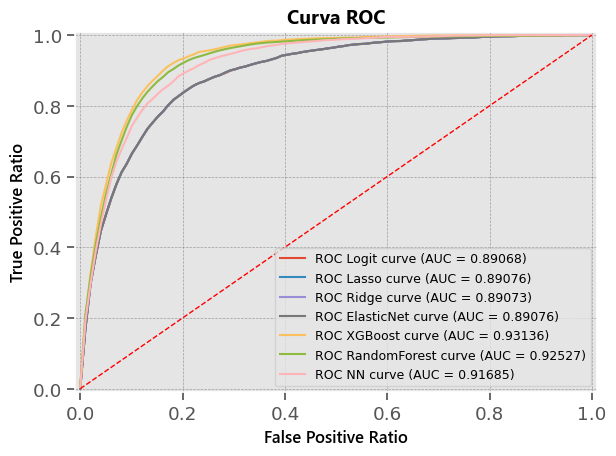

In [348]:
plt.figure()
for model in save_model:
  mean_fpr = save_model[model]['mean_fpr'][0]
  mean_tpr = save_model[model]['mean_tpr'][0]
  mean_auc = save_model[model]["mean_auc"][0]

  plt.plot(mean_fpr, mean_tpr, lw=1.5, label=f'ROC {model} curve (AUC = {mean_auc:.5f})')

plt.plot([0, 1], [0, 1], color='red', lw=1, linestyle='--') 

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])

plt.title(f'Curva ROC',fontdict=font1)
plt.xlabel('False Positive Ratio', fontdict=font2)
plt.ylabel('True Positive Ratio', fontdict=font2)

plt.legend(loc='lower right', fontsize=9)
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()

### **Exportar Mejor Modelo**

In [356]:
import joblib

model = save_model['XGBoost']['model']
model.fit(X, Y)

joblib.dump(model, 'model_xgb.joblib')

['model_xgb.joblib']